# Take Home Exercise 2 st121411

Using the dataset you played with for the take-home exercise in Lab 01, perform the same analysis. You won't be able to visualize the model well, as you will have more than two inputs, but try to give some idea of the performance of the model visually. Also, depending on the number of variables in your dataset, you may not be able to increase the polynomial degree beyond 2. Discuss whether the polynomial model is better than the linear model and whether you observe overfitting.

In [1]:
# import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#import raw data

raw_data = np.genfromtxt('../resources/avocado.csv', delimiter=",", dtype=str)
#delete irrelevant data for linear regression
selected_raw_data = np.delete(raw_data, [0,1,3,4,5,6,7,8,9,10,13],1)
#get the headers
headers = selected_raw_data[0]
print("headers:",headers)
#delete the first row containing the headers
selected_raw_data = np.delete(selected_raw_data, 0,0)
#convert "organic" and "conventional" to their respective unique integers
types, indexed_type = np.unique(selected_raw_data[:,1], return_inverse=True)
selected_raw_data[:,1] = indexed_type
print("Types [0,1]:")
print(types)
#convert selected data to float
data = np.array(selected_raw_data[1:,:],dtype=float)
print("Data:")
print(data)

headers: ['AveragePrice' 'type' 'year']
Types [0,1]:
['conventional' 'organic']
Data:
[[1.350e+00 0.000e+00 2.015e+03]
 [9.300e-01 0.000e+00 2.015e+03]
 [1.080e+00 0.000e+00 2.015e+03]
 ...
 [1.870e+00 1.000e+00 2.018e+03]
 [1.930e+00 1.000e+00 2.018e+03]
 [1.620e+00 1.000e+00 2.018e+03]]


In [3]:
#create normalized version of the data

mean = np.mean(data,axis=0)
std = np.std(data, axis=0)
data_norm = (data-mean)/std

In [4]:
#create X, y

X_un = data[:,[1,2]]
y_un = data[:,0]
X = data_norm[:,[1,2]]
y = data_norm[:,0]

m = X.shape[0]
n = X.shape[1]

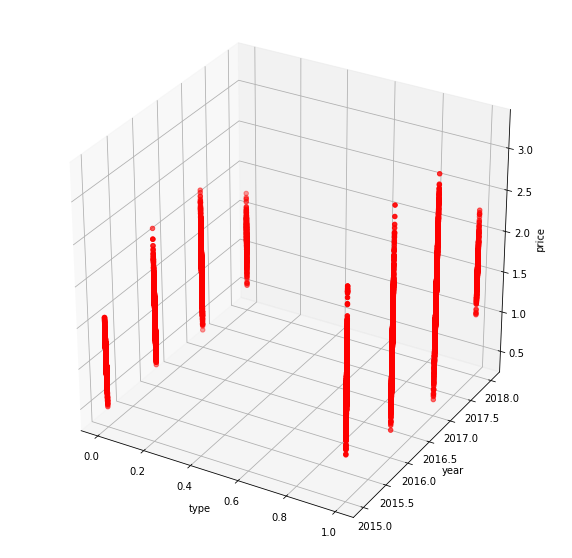

In [5]:
#plot out the data

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
fig_data = fig.add_subplot(111, projection='3d')

fig_data.scatter(X_un[:,0],X_un[:,1],y_un, c='r', marker='o')

fig_data.set_xlabel('type')
fig_data.set_ylabel('year')
fig_data.set_zlabel('price')

plt.show()

In [6]:
#Functions for regression

from itertools import combinations_with_replacement

# Cost function normalized by number of examples
def J(theta,X,y):
    return 1 /(2*X.shape[0]) * (h(X,theta)-y).T.dot(h(X,theta)-y)

# Get design matrix for polynomial model of degree d
def x_polynomial(x, d):
    x_new = x
    for n in np.arange(2,d+1):
        comb = combinations_with_replacement(np.arange(x.shape[1]),n)
        for pair in comb:
            x_new_column = np.ones((x.shape[0],1))
            for i in pair:
                vector = x[:,i].reshape(-1,1)
                x_new_column = x_new_column*vector
            x_new = np.concatenate((x_new,x_new_column),axis=1)
    
    x_new = np.concatenate((np.ones(x.shape[0]).reshape(-1,1),x_new),axis=1)
    return x_new

# Expects an mxn matrix, returns mx(n+degree) matrix for polynomial regression
def get_predictions(x, theta):
    x = np.insert(x, 0, 1, axis=1)
    while(x.shape[1] < theta.shape[0]):
        x = np.insert(x, x.shape[1], x[:,1] * x[:,-1], axis=1)
    y = h(x, theta)
    return y

def get_predictions2(x, theta):
    theta = theta.reshape(-1,1)
    y = x@theta
    return y

def h(X, theta):
    return X.dot(theta)

# Solve the normal equations
def regress(X, y):
    cov = np.dot(X.T, X)
    cov_inv = np.linalg.inv(cov)
    theta = np.dot(cov_inv, np.dot(X.T, y))
    return theta

# RMSE (root mean squared error) metric for prediction accuracy
def rmse(y, y_pred):
    return np.sqrt(np.dot((y - y_pred).T, y - y_pred) / m)

def r_squared(y, y_pred):
    return 1 - np.square(y - y_pred).sum() / np.square(y - y.mean()).sum()


In [7]:
#get the partition

import random

idx = np.arange(0,m)
random.shuffle(idx)

percent_train = 0.9
m_train = int(m * percent_train)
train_idx = idx[0:m_train]
test_idx = idx[m_train:m+1]

X_norm_train = X[train_idx]
X_norm_test = X[test_idx]
y_norm_train = y[train_idx]
y_norm_test = y[test_idx]

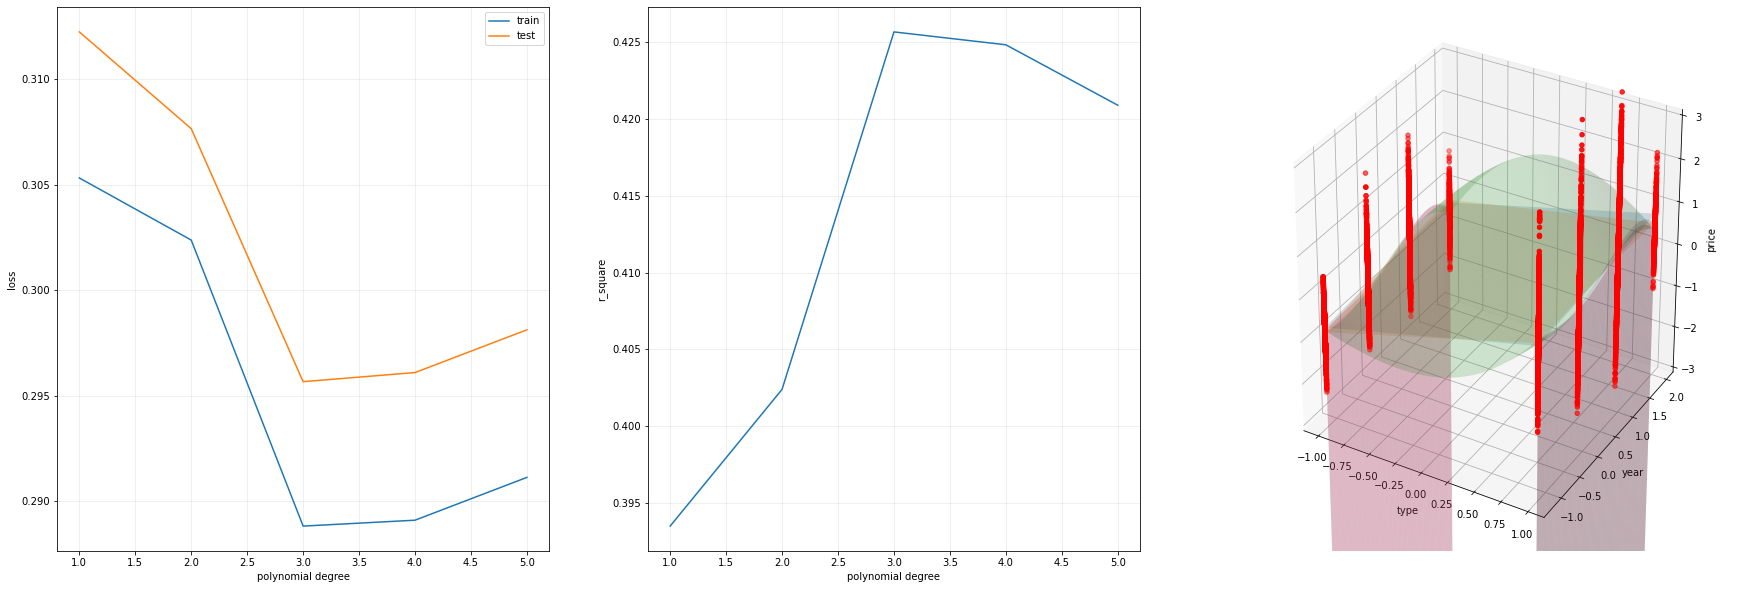

In [14]:
#find prediction

# Build models of degree 1 to max_degree
min_degree = 1
max_degree = 5

J_norm_train = np.zeros(max_degree-min_degree+1)
J_norm_test = np.zeros(max_degree-min_degree+1)

r_norm = np.zeros(max_degree-min_degree+1)

# Initalize plots for predictions and loss
fig = plt.figure(figsize=(30,10))
gs = fig.add_gridspec(1, 3)
fig_norm_cost = fig.add_subplot(gs[0,0])
fig_norm_r = fig.add_subplot(gs[0,1])
fig_norm_plot = fig.add_subplot(gs[0,2], projection='3d')

fig_norm_plot.set_zlim([-3,3])

fig_norm_plot.scatter(X[:,0], X[:,1], y, c='r', marker='o')
fig_norm_plot.set_xlabel('type')
fig_norm_plot.set_ylabel('year')
fig_norm_plot.set_zlabel('price')

#fig_norm_plot.view_init(15, 30)

for i in range(min_degree, max_degree+1):
    # Fit model on training data and get cost for training and test data
    Xi_norm_train = x_polynomial(X_norm_train, i)    
    Xi_norm_test = x_polynomial(X_norm_test, i);
    
    theta_norm = regress(Xi_norm_train, y_norm_train)  
    J_norm_train[i-min_degree] = J(theta_norm, Xi_norm_train, y_norm_train)
    y_norm_pred_test = h(Xi_norm_test, theta_norm)
    J_norm_test[i-min_degree] = J(theta_norm, Xi_norm_test, y_norm_test)
    
    r_norm[i-min_degree] = r_squared(y_norm_test, y_norm_pred_test)
    
    # Plot
    spacing = 100

    x_norm_series = np.linspace(np.min(X[:,0]),np.max(X[:,0]),spacing)
    y_norm_series = np.linspace(np.min(X[:,1]),np.max(X[:,1]), spacing)
    
    x_norm_series, y_norm_series = np.meshgrid(x_norm_series, y_norm_series)
    #X_Y = np.append(X[...,np.newaxis],Y[...,np.newaxis],axis=2)
    X_Y = np.concatenate((x_norm_series.reshape(-1,1), y_norm_series.reshape(-1,1)), axis=1) 
    X_Y = x_polynomial(X_Y, i)
    z_norm = get_predictions2(X_Y, theta_norm).reshape(spacing,spacing)

    fig_norm_plot.plot_surface(x_norm_series,y_norm_series,z_norm,alpha=0.2,label='degree ' + str(i) + ' (test accuracy ' + str(r_squared(y_norm_test, y_norm_pred_test)) + ')')
    
    
  #  x0_series = np.linspace(0, 13, 1000)
  #  y_series = get_predictions(x_series, theta)
  # plt2.plot(x_series, y_series, '-', label='degree ' + str(i) + ' (test accuracy ' + str(r_squared(y_test, y_pred_test)) + ')')

fig_norm_cost.plot(np.arange(min_degree, max_degree + 1, 1), J_norm_train, '-', label='train')
fig_norm_cost.plot(np.arange(min_degree, max_degree + 1, 1), J_norm_test, '-', label='test')
fig_norm_cost.set_xlabel('polynomial degree')
fig_norm_cost.set_ylabel('loss')
fig_norm_cost.grid(axis='both', alpha=.25)
fig_norm_cost.legend()

fig_norm_r.plot(np.arange(min_degree, max_degree + 1, 1), r_norm, '-')
fig_norm_r.set_xlabel('polynomial degree')
fig_norm_r.set_ylabel('r_square')
fig_norm_r.grid(axis='both', alpha=.25)


# fig_unnorm_plot.legend()
# fig_norm_plot.legend()

#plt.show()

The graphs above shows the loss, r_square, and the surface plot of the predictions. From the loss graph, it could be noted that we did not observe overfitting because the training data doesn't indefinitely decrease. This may be due to difficulties in numerically obtaining the inverse of its matrix at higher orders. This is because having higher orders gives more freedom for the surface, but when the data is not continuous(type of avocados which corresponds to 0 or 1), there are several surfaces that can be very close to the opitimal surface, thus making it unstable when finding the optimum parameters using the normal equation. This finding thus shows us the limits of polynomial regression on ceretain types of data. Nonetheless, the highest r_square value obtained was 0.43 with the polynomial degree of 3. This value is higher than purely using a linear regression alone. Thus this concludes that polynomial regression is a better fit for this dataset compared to a linear model.